In [2]:
pip install polars NLTK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.1/26.1 MB 26.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 15.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import polars as pl
import altair as alt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import re
import nltk

# Ensure NLTK resources are downloaded
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


False

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


False

In [28]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


2024-07-21 20:44:42.500 Python[7705:2636732] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-07-21 20:47:10.521 Python[7705:2636732] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_inputSessionDoneSleepWithReply:) block performed very slowly (2.39 secs).


True

In [24]:

# Load training data
data_train = pl.read_csv('/Users/girimanoharv/Documents/Social-Media-Sentiment-Analysis/Dataset/English/EI-oc/training/EI-oc-En-anger-train.txt', separator='\t')
data_train = data_train.rename({"ID": "ID", "Tweet": "Tweet", "Affect Dimension": "Affect_Dimension", "Intensity Class": "Intensity_Class"})

data_dev = pl.read_csv('/Users/girimanoharv/Documents/Social-Media-Sentiment-Analysis/Dataset/English/EI-oc/development/2018-EI-oc-En-anger-dev.txt', separator='\t')
data_dev = data_dev.rename({"ID": "ID", "Tweet": "Tweet", "Affect Dimension": "Affect_Dimension", "Intensity Class": "Intensity_Class"})

data_test = pl.read_csv('/Users/girimanoharv/Documents/Social-Media-Sentiment-Analysis/Dataset/English/EI-oc/test-gold/2018-EI-oc-En-anger-test-gold.txt', separator='\t')
data_test = data_test.rename({"ID": "ID", "Tweet": "Tweet", "Affect Dimension": "Affect_Dimension", "Intensity Class": "Intensity_Class"})
# Concatenate training and development data
data_train = pl.concat([data_train, data_dev])

# Mapping of categorical values to numeric codes
intensity_mapping = {
    "0: no anger can be inferred": 0,
    "1: low amount of anger can be inferred": 1,
    "2: moderate amount of anger can be inferred": 2,
    "3: high amount of anger can be inferred": 3
}

data_train = data_train.with_columns(
    pl.Series("Intensity_Class", [intensity_mapping[x] for x in data_train["Intensity_Class"]])
)

# Convert categorical labels to numerical codes for test data
data_test = data_test.with_columns(
    pl.Series("Intensity_Class", [intensity_mapping[x] for x in data_test["Intensity_Class"]])
)
# Display the first few rows to verify
print(data_train.head())
print(data_test.head())

shape: (5, 4)
┌───────────────┬─────────────────────────────────┬──────────────────┬─────────────────┐
│ ID            ┆ Tweet                           ┆ Affect_Dimension ┆ Intensity_Class │
│ ---           ┆ ---                             ┆ ---              ┆ ---             │
│ str           ┆ str                             ┆ str              ┆ i64             │
╞═══════════════╪═════════════════════════════════╪══════════════════╪═════════════════╡
│ 2017-En-10264 ┆ @xandraaa5 @amayaallyn6 shut u… ┆ anger            ┆ 2               │
│ 2017-En-10072 ┆ it makes me so fucking irate j… ┆ anger            ┆ 3               │
│ 2017-En-11383 ┆ Lol Adam the Bull with his fak… ┆ anger            ┆ 1               │
│ 2017-En-11102 ┆ @THATSSHAWTYLO passed away ear… ┆ anger            ┆ 0               │
│ 2017-En-11506 ┆ @Kristiann1125 lol wow i was g… ┆ anger            ┆ 1               │
└───────────────┴─────────────────────────────────┴──────────────────┴─────────────────┘
shape: 

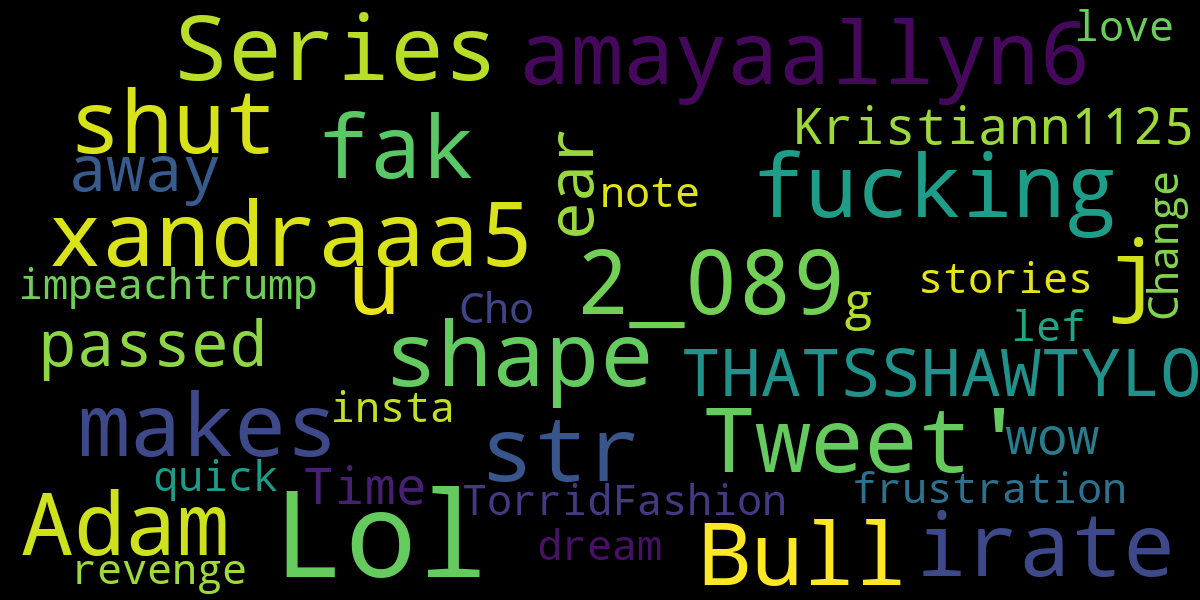

In [32]:
from IPython.display import display, Image
stop_words = set(stopwords.words('english'))
stop_words.update(["now", "let", 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'may', 'also', 'across', 'among', 'beside', 'however', 'yet', 'within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

# Function to create a word cloud and save it as an image file
def create_wordcloud(data):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stop_words,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1  # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    wordcloud.to_file("wordcloud.png")
    return "wordcloud.png"

# Generate the word cloud image for the training data tweets
wordcloud_image = create_wordcloud(data_train["Tweet"])

# Display the word cloud image
display(Image(filename=wordcloud_image))

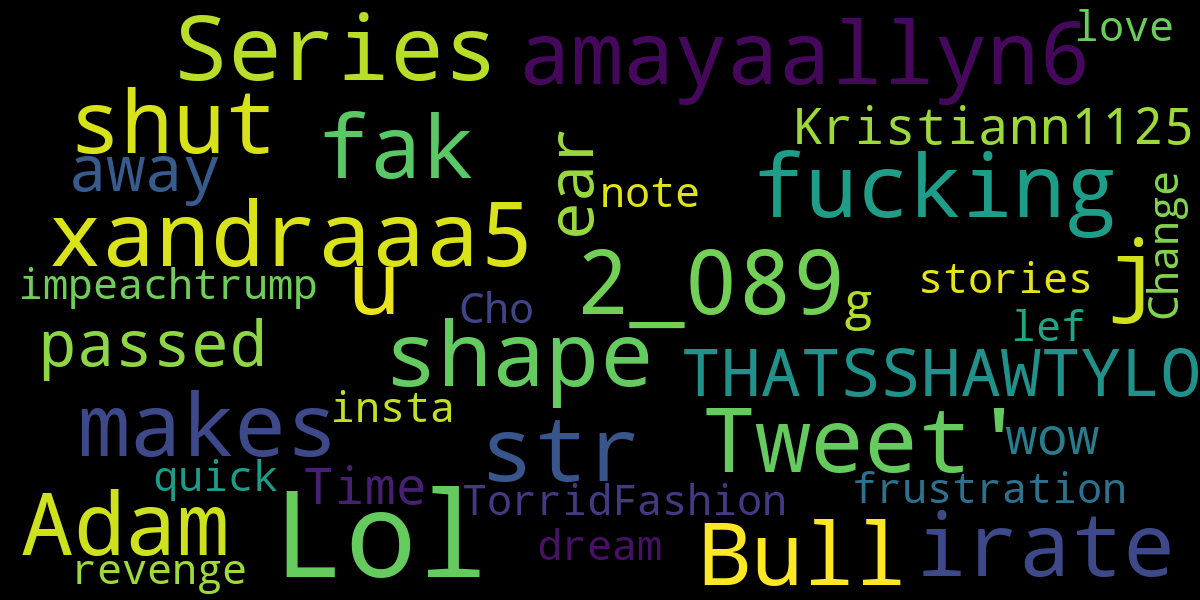

In [35]:
from PIL import Image as PILImage
def create_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stop_words,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1  # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    image_path = f"{title}.png"
    wordcloud.to_file(image_path)
    return image_path

# Function to display the word cloud image
def display_wordcloud(image_path, title):
    img = PILImage.open(image_path)
    display(img)

# Generate and display word clouds
image_path = create_wordcloud(data_train['Tweet'], 'Most_Common_Words')
display_wordcloud(image_path, 'Most Common Words from the Whole Corpus')


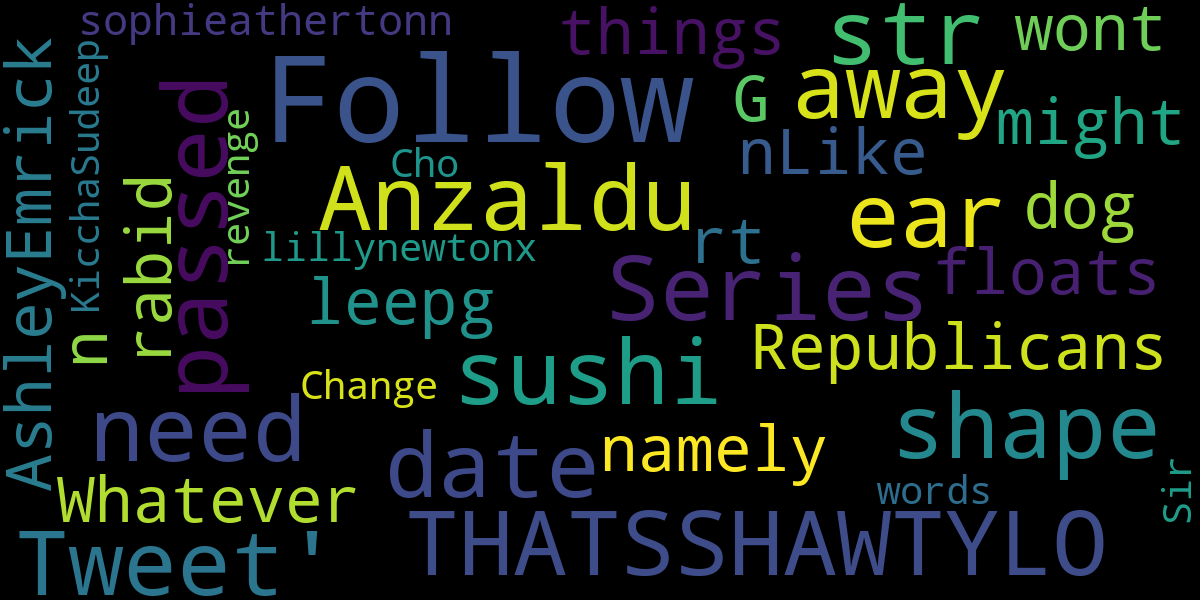

In [36]:
image_path = create_wordcloud(data_train.filter(pl.col('Intensity_Class') == 0)['Tweet'], 'No_E_Inferred')
display_wordcloud(image_path, 'No Anger Can Be Inferred')


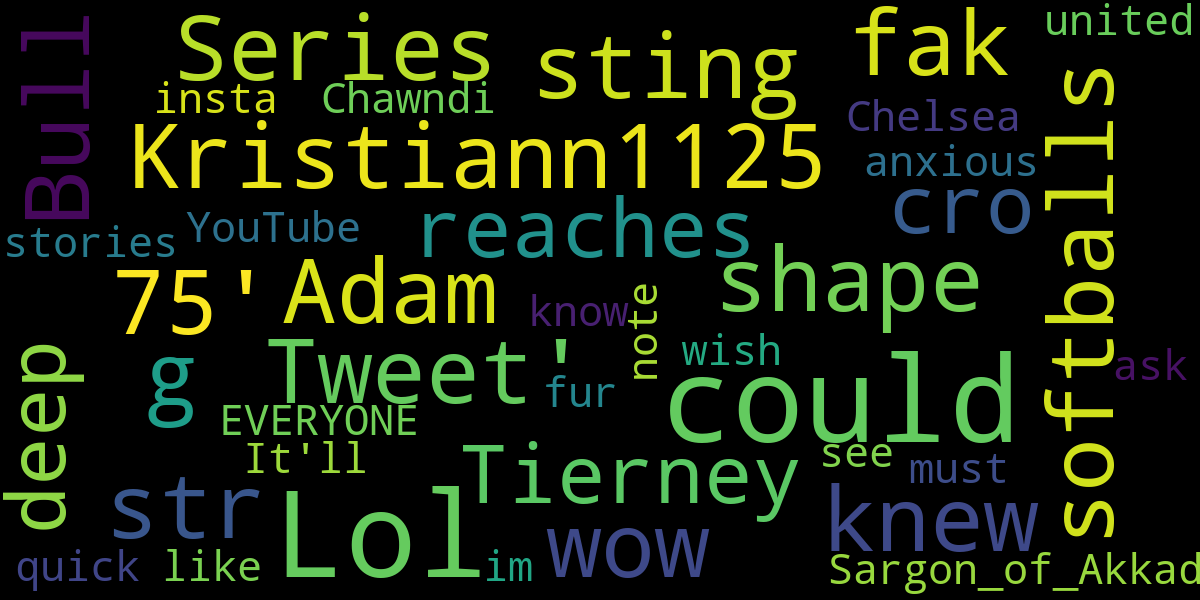

In [37]:
image_path = create_wordcloud(data_train.filter(pl.col('Intensity_Class') == 1)['Tweet'], 'Low_Amount_E_Inferred')
display_wordcloud(image_path, 'Low Amount of Anger Can Be Inferred')


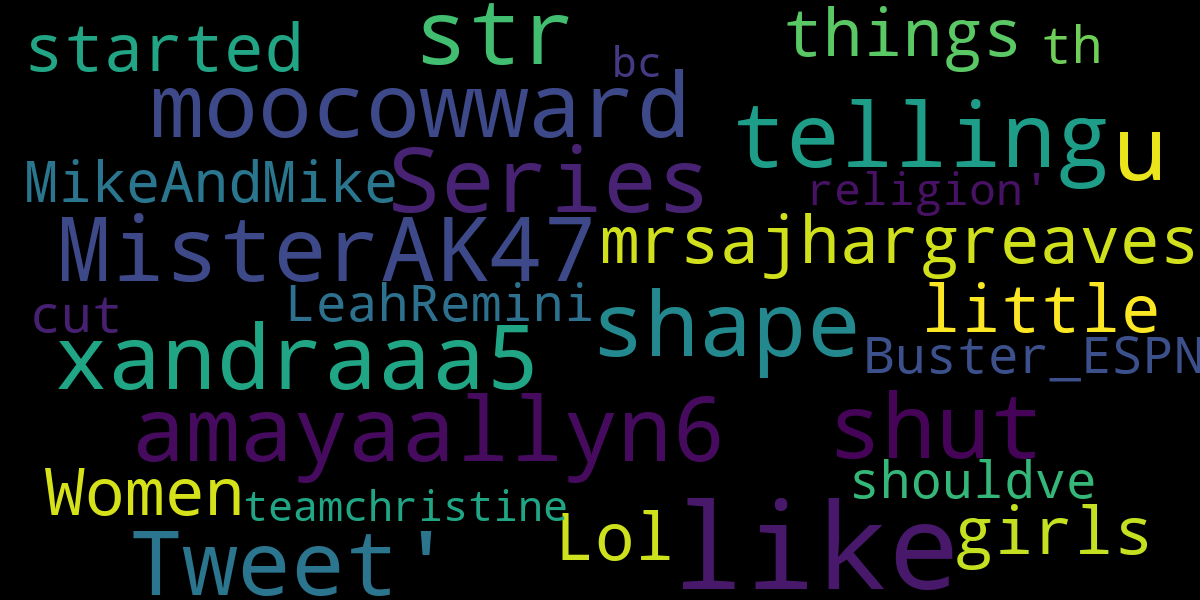

In [38]:
image_path = create_wordcloud(data_train.filter(pl.col('Intensity_Class') == 2)['Tweet'], 'Moderate_Amount_E_Inferred')
display_wordcloud(image_path, 'Moderate Amount of Anger Can Be Inferred')


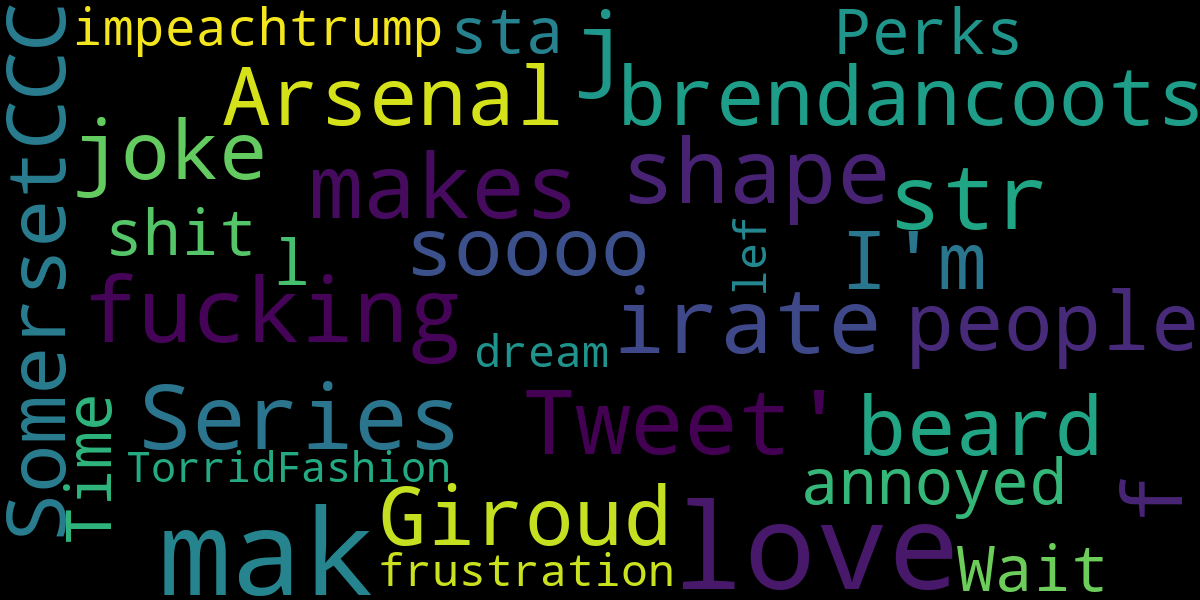

In [39]:
image_path = create_wordcloud(data_train.filter(pl.col('Intensity_Class') == 3)['Tweet'], 'High_Amount_E_Inferred')
display_wordcloud(image_path, 'High Amount of Anger Can Be Inferred')

In [10]:
load_data('/Users/girimanoharv/Documents/Social-Media-Sentiment-Analysis/Dataset/English/EI-oc/training/EI-oc-En-anger-train.txt',"/Users/girimanoharv/Documents/Social-Media-Sentiment-Analysis/Dataset/English/EI-oc/development/2018-EI-oc-En-anger-dev.txt",'/Users/girimanoharv/Documents/Social-Media-Sentiment-Analysis/Dataset/English/EI-oc/test-gold/2018-EI-oc-En-anger-test-gold.txt')

AttributeError: 'DataFrame' object has no attribute 'with_column'

In [5]:
def visualize_class_distribution(data_train):
    """
    Visualize the distribution of classes in the training dataset using Altair.
    """
    class_count = data_train.groupby("Intensity_Class").count()
    class_count = class_count.to_pandas()

    chart = alt.Chart(class_count).mark_bar().encode(
        x='Intensity_Class:O',
        y='count:Q'
    ).properties(
        title='Class Distribution in Training Data',
        width=600,
        height=400
    )

    chart.show()

In [6]:
# Function to preprocess text data
def preprocess_text(text, stemmer, stop_words):
    """
    Preprocess text data by removing special characters, stop words, and stemming.
    """
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stop_words]
    return ' '.join(text)

In [7]:
def preprocess_dataset(data):
    """
    Preprocess all tweets in the dataset using Polars.
    """
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    data = data.with_column(
        pl.col("Tweet").apply(lambda x: preprocess_text(x, stemmer, stop_words)).alias("Processed_Tweet")
    )

    return data

In [8]:
def main():
    # File paths
    train_file = 'EI-oc-En-anger-train.txt'
    dev_file = 'EI-oc-En-anger-dev.txt'
    test_file = 'EI-oc-En-anger-test.txt'

    # Load and preprocess data
    data_train, data_test = load_data(train_file, dev_file, test_file)
    data_train = preprocess_dataset(data_train)
    data_test = preprocess_dataset(data_test)

    # Visualize class distribution
    visualize_class_distribution(data_train)